# GDS geometries and MEEP

## 2D

Some imports and parameters as usual :

In [1]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt
import ipyvolume as ipv

Using MPI version 3.1, 1 processes


In [2]:
oxide=mp.Medium(epsilon=2.25)
silicon=mp.Medium(epsilon=12)

res = 32        # pixels/μm

Last week you were introduced to zeropdk, a way to create GDS masks. You can directly upload your GDS masks into MEEP for simulation! You just need to add dummy layers to define your simulation ports. It is as easy as calling `mp.get_GDSII_prisms` with a material, GDS file, and layer number (figure from https://meep.readthedocs.io/en/latest/Python_Tutorials/GDSII_Import/) :

!['gds_coupler'](https://meep.readthedocs.io/en/latest/images/klayout_schematic.png)

In [3]:
gdsII_file = 'coupler.gds'

CELL_LAYER = 0
UPPER_BRANCH_LAYER = 31
LOWER_BRANCH_LAYER = 32 # They have two layers of silicon here to parametrize the distance between the branches at this level

upper_branch = mp.get_GDSII_prisms(silicon, gdsII_file, UPPER_BRANCH_LAYER)
lower_branch = mp.get_GDSII_prisms(silicon, gdsII_file, LOWER_BRANCH_LAYER)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, zmin=0, zmax=0) # for 2D simulation, don't care about zmin and zmax

Dummy layers can also be included to precisely denote the positions of the input port for the simulation :

In [4]:
SOURCE_LAYER = 5

src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, zmin=0, zmax=0)

Then repeat simulation definition as before :

In [5]:
dpml = 1

lcen = 1.55
fcen = 1/lcen
df = 0.2*fcen

geometry = upper_branch+lower_branch

sources = [mp.EigenModeSource(src=mp.ContinuousSource(fcen,fwidth=df),
                              size=src_vol.size,
                              center=src_vol.center,
                              eig_band=1,
                              eig_parity=mp.EVEN_Y+mp.ODD_Z,
                              eig_match_freq=True)]

sim = mp.Simulation(resolution=res,
                    cell_size=cell.size,
                    boundary_layers=[mp.PML(dpml)],
                    sources=sources,
                    geometry=geometry)

In [6]:
sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000226974 s
Working in 2D dimensions.
Computational cell is 34.4062 x 8 x 0 with resolution 32
     prism, center = (-9.09425,1.41149,0)
          height 0, axis (0,0,1), 174 vertices:
          (-4,0.15,0)
          (-4.108,0.151,0)
          (-4.215,0.152,0)
          (-4.322,0.155,0)
          (-4.429,0.16,0)
          (-4.535,0.165,0)
          (-4.641,0.171,0)
          (-4.747,0.179,0)
          (-4.852,0.187,0)
          (-5.062,0.207,0)
          (-5.167,0.219,0)
          (-5.271,0.231,0)
          (-5.479,0.259,0)
          (-5.582,0.274,0)
          (-5.685,0.29,0)
          (-5.788,0.307,0)
          (-5.891,0.325,0)
          (-5.993,0.343,0)
          (-6.095,0.362,0)
          (-6.197,0.382,0)
          (-6.299,0.403,0)
          (-6.4,0.424,0)
          (-6.501,0.446,0)
          (-6.703,0.492,0)
          (-6.803,0.515,0)
          (-6.904,0.54,0)
          (-7.204,0.615,0)
          (-7.303,0.642,

          (10.63,1.623,0)
          (10.533,1.596,0)
          (10.436,1.568,0)
          (10.338,1.541,0)
          (10.144,1.485,0)
          (10.047,1.456,0)
          (9.949,1.427,0)
          (9.658,1.34,0)
          (9.56,1.31,0)
          (9.463,1.281,0)
          (9.366,1.251,0)
          (9.268,1.221,0)
          (9.074,1.161,0)
          (8.878,1.101,0)
          (8.781,1.071,0)
          (8.585,1.011,0)
          (8.487,0.982,0)
          (8.389,0.952,0)
          (8.291,0.923,0)
          (8.193,0.893,0)
          (8.095,0.864,0)
          (7.996,0.835,0)
          (7.898,0.807,0)
          (7.799,0.778,0)
          (7.7,0.75,0)
          (7.601,0.723,0)
          (7.502,0.695,0)
          (7.403,0.668,0)
          (7.303,0.642,0)
          (7.204,0.615,0)
          (6.904,0.54,0)
          (6.803,0.515,0)
          (6.703,0.492,0)
          (6.501,0.446,0)
          (6.4,0.424,0)
          (6.299,0.403,0)
          (6.197,0.382,0)
          (6.095,0.362,0)
          (5.993

          (7.856,-1.315,0)
          (7.662,-1.259,0)
          (7.564,-1.232,0)
          (7.467,-1.204,0)
          (7.37,-1.177,0)
          (7.272,-1.151,0)
          (7.078,-1.099,0)
          (6.98,-1.074,0)
          (6.883,-1.05,0)
          (6.785,-1.025,0)
          (6.687,-1.002,0)
          (6.59,-0.979,0)
          (6.492,-0.956,0)
          (6.394,-0.934,0)
          (6.296,-0.913,0)
          (6.198,-0.893,0)
          (6.099,-0.873,0)
          (6.001,-0.854,0)
          (5.902,-0.835,0)
          (5.804,-0.817,0)
          (5.705,-0.8,0)
          (5.606,-0.784,0)
          (5.408,-0.754,0)
          (5.309,-0.74,0)
          (5.209,-0.728,0)
          (5.11,-0.716,0)
          (5.01,-0.705,0)
          (4.81,-0.685,0)
          (4.709,-0.677,0)
          (4.608,-0.67,0)
          (4.508,-0.664,0)
          (4.407,-0.659,0)
          (4.305,-0.655,0)
          (4.204,-0.652,0)
          (4,-0.65,0)
          (4,-0.15,0)
          (4.108,-0.151,0)
          (4.215,-0.15

Look at the geometry before simulating :

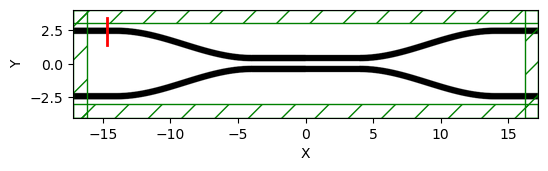

In [7]:
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

Simulate for the fields :

In [8]:
sim.run(until=400)  # arbitrary long run time to ensure that fields have reached steady state

Meep progress: 64.140625/400.0 = 16.0% done in 4.0s, 20.9s to go
on time step 4105 (time=64.1406), 0.000974545 s/step
Meep progress: 129.265625/400.0 = 32.3% done in 8.0s, 16.8s to go
on time step 8275 (time=129.297), 0.000959429 s/step
Meep progress: 194.359375/400.0 = 48.6% done in 12.0s, 12.7s to go
on time step 12443 (time=194.422), 0.000959915 s/step
Meep progress: 259.421875/400.0 = 64.9% done in 16.0s, 8.7s to go
on time step 16608 (time=259.5), 0.000960471 s/step
Meep progress: 324.484375/400.0 = 81.1% done in 20.0s, 4.7s to go
on time step 20774 (time=324.594), 0.000960194 s/step
Meep progress: 389.546875/400.0 = 97.4% done in 24.0s, 0.6s to go
on time step 24940 (time=389.688), 0.000960313 s/step
run 0 finished at t = 400.0 (25600 timesteps)


Plot the result :

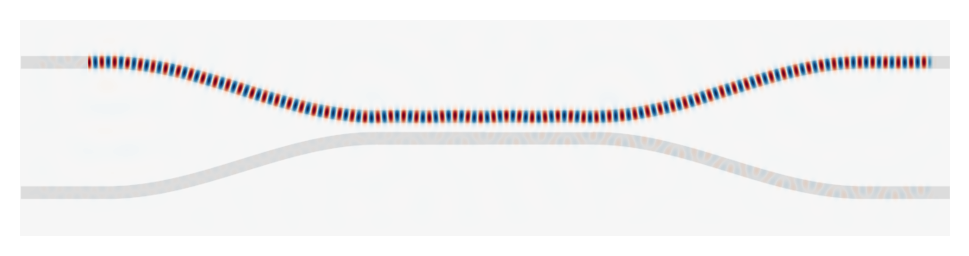

In [9]:
eps_data = sim.get_epsilon()
ez_data = np.real(sim.get_efield_z())

plt.figure(dpi=200)
plt.imshow(np.transpose(eps_data), interpolation='spline36', cmap='binary')
plt.imshow(np.flipud(np.transpose(ez_data)), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

## Extruding to 3D

We can also give a $z_{min}$ and $z_{max}$ argument to the layers when we load them for 3D simulations.

In [10]:
sim.reset_meep()

t_oxide = 1.0
t_Si = 0.22
t_air = 0.78

cell_thickness = dpml+t_oxide+t_Si+t_air+dpml
si_zmin = 0

cell_zmax = 0.5*cell_thickness
cell_zmin = -0.5*cell_thickness
si_zmax = t_Si

In [11]:
upper_branch = mp.get_GDSII_prisms(silicon, gdsII_file, UPPER_BRANCH_LAYER, si_zmin, si_zmax)
lower_branch = mp.get_GDSII_prisms(silicon, gdsII_file, LOWER_BRANCH_LAYER, si_zmin, si_zmax)
geometry = upper_branch+lower_branch

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)

oxide_center = mp.Vector3(z=-0.5*t_oxide)
oxide_size = mp.Vector3(cell.size.x,cell.size.y,t_oxide)
oxide_layer = [mp.Block(material=oxide, center=oxide_center, size=oxide_size)]
geometry = geometry+oxide_layer

# Uncomment this to setup the simulations. Takes a while to run!
sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                             size=src_vol.size,
                             center=src_vol.center,
                             eig_band=1,
                             eig_parity=mp.NO_PARITY,
                             eig_match_freq=True)]

# Display simulation object
sim = mp.Simulation(resolution=res,
                   eps_averaging=False,
                   subpixel_maxeval=1,
                   subpixel_tol=1,
                   cell_size=cell.size,
                   boundary_layers=[mp.PML(dpml)],
                   sources=sources,
                   geometry=geometry)

In [12]:
sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000792027 s
Working in 3D dimensions.
Computational cell is 34.4062 x 8 x 4 with resolution 32
     prism, center = (-9.09425,1.41149,0.11)
          height 0.22, axis (0,0,1), 174 vertices:
          (-4,0.15,0)
          (-4.108,0.151,0)
          (-4.215,0.152,0)
          (-4.322,0.155,0)
          (-4.429,0.16,0)
          (-4.535,0.165,0)
          (-4.641,0.171,0)
          (-4.747,0.179,0)
          (-4.852,0.187,0)
          (-5.062,0.207,0)
          (-5.167,0.219,0)
          (-5.271,0.231,0)
          (-5.479,0.259,0)
          (-5.582,0.274,0)
          (-5.685,0.29,0)
          (-5.788,0.307,0)
          (-5.891,0.325,0)
          (-5.993,0.343,0)
          (-6.095,0.362,0)
          (-6.197,0.382,0)
          (-6.299,0.403,0)
          (-6.4,0.424,0)
          (-6.501,0.446,0)
          (-6.703,0.492,0)
          (-6.803,0.515,0)
          (-6.904,0.54,0)
          (-7.204,0.615,0)
          (-7.303,

          (10.63,1.623,0)
          (10.533,1.596,0)
          (10.436,1.568,0)
          (10.338,1.541,0)
          (10.144,1.485,0)
          (10.047,1.456,0)
          (9.949,1.427,0)
          (9.658,1.34,0)
          (9.56,1.31,0)
          (9.463,1.281,0)
          (9.366,1.251,0)
          (9.268,1.221,0)
          (9.074,1.161,0)
          (8.878,1.101,0)
          (8.781,1.071,0)
          (8.585,1.011,0)
          (8.487,0.982,0)
          (8.389,0.952,0)
          (8.291,0.923,0)
          (8.193,0.893,0)
          (8.095,0.864,0)
          (7.996,0.835,0)
          (7.898,0.807,0)
          (7.799,0.778,0)
          (7.7,0.75,0)
          (7.601,0.723,0)
          (7.502,0.695,0)
          (7.403,0.668,0)
          (7.303,0.642,0)
          (7.204,0.615,0)
          (6.904,0.54,0)
          (6.803,0.515,0)
          (6.703,0.492,0)
          (6.501,0.446,0)
          (6.4,0.424,0)
          (6.299,0.403,0)
          (6.197,0.382,0)
          (6.095,0.362,0)
          (5.993

          (7.953,-1.344,0)
          (7.856,-1.315,0)
          (7.662,-1.259,0)
          (7.564,-1.232,0)
          (7.467,-1.204,0)
          (7.37,-1.177,0)
          (7.272,-1.151,0)
          (7.078,-1.099,0)
          (6.98,-1.074,0)
          (6.883,-1.05,0)
          (6.785,-1.025,0)
          (6.687,-1.002,0)
          (6.59,-0.979,0)
          (6.492,-0.956,0)
          (6.394,-0.934,0)
          (6.296,-0.913,0)
          (6.198,-0.893,0)
          (6.099,-0.873,0)
          (6.001,-0.854,0)
          (5.902,-0.835,0)
          (5.804,-0.817,0)
          (5.705,-0.8,0)
          (5.606,-0.784,0)
          (5.408,-0.754,0)
          (5.309,-0.74,0)
          (5.209,-0.728,0)
          (5.11,-0.716,0)
          (5.01,-0.705,0)
          (4.81,-0.685,0)
          (4.709,-0.677,0)
          (4.608,-0.67,0)
          (4.508,-0.664,0)
          (4.407,-0.659,0)
          (4.305,-0.655,0)
          (4.204,-0.652,0)
          (4,-0.65,0)
          (4,-0.15,0)
          (4.108,-0.15

Usually (say on your own machine), you can use Mayavi to easily visualize in 3D with `sim.plot3D`. The graphical backend of the cluster doesn't allow for Mayavi, so we can look at cuts :

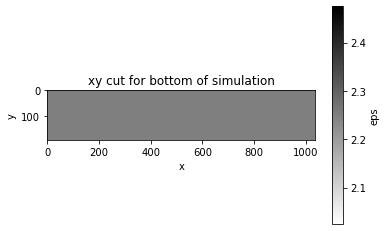

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

eps = sim.get_epsilon()
eps = eps[dpml*res:-1*dpml*res, dpml*res:-1*dpml*res, dpml*res:-1*dpml*res] # Trim PMLs
eps_xy = eps[:,:,0]

pos = ax.imshow(eps_xy.T, cmap='gray_r', interpolation='none')
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('eps')
ax.set_title('xy cut for bottom of simulation')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

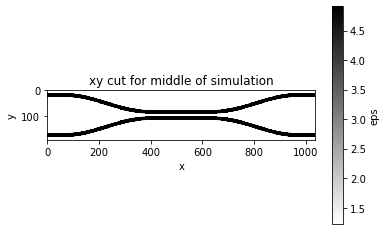

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))

eps_xy = eps[:,:,32]

pos = ax.imshow(eps_xy.T, cmap='gray_r', interpolation='none')
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('eps')
ax.set_title('xy cut for middle of simulation')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [19]:
np.shape(eps)

(1037, 192, 64)